In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import time
%matplotlib inline

In [2]:
# physical parameters
q = 1.60217662e-19 # coulombs
#m = 9.10938356e-31 #kg (electron)
m = 6.6359437706294e-26 #(calcium)
kB = 1.38064852e-23 # J/K
f = 100.0e6 # Electrode frequency, in Hertz

In [3]:
# loading E field (vector)
data = np.loadtxt("Fusion3D_100MHz_50V_ion_oop_realExEy_smooth.fld", skiprows = 2)

In [4]:
# manipulating E field data
df = pd.DataFrame(data, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max, x_min = df.x.max(), df.x.min()
y_max, y_min = df.y.max(), df.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx, Ny = df.x.nunique() - 1, df.y.nunique() - 1 # numbers of intervals that divide each dimension
dx, dy = (x_max-x_min)/Nx, (y_max-y_min)/Ny # interval size
print("x_max = ", x_max*1.0e3, "mm")
print("y_max = ", y_max*1.0e3, "mm")
print("x_min = ", x_min*1.0e3, "mm")
print("y_min = ", y_min*1.0e3, "mm")
print("spatial resolution x: ", dx*1.0e6, "um")
print("spatial resolution y: ", dy*1.0e6, "um")

x_max =  0.25 mm
y_max =  0.25 mm
x_min =  -0.25 mm
y_min =  -0.25 mm
spatial resolution x:  0.5 um
spatial resolution y:  0.5 um


x        -0.000250
y        -0.000250
z         0.000000
Ex    55360.578175
Ey    55298.222957
Ez        0.000000
Name: 0, dtype: float64


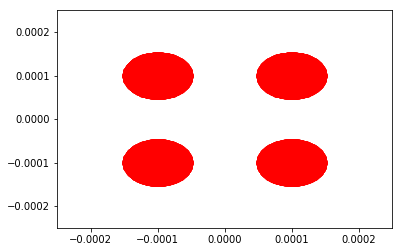

In [20]:
electrode = df.loc[(np.abs(df["Ex"]) < 1.0e-8) & (np.abs(df["Ey"]) < 1.0e-8)]
x_electrode = electrode.iloc[:, 0].values
y_electrode = electrode.iloc[:, 1].values
plt.plot(x_electrode, y_electrode, "r.")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))

print(df.iloc[0, :])

In [21]:
def get_row_index(x, y):
    # given spatial coordinates x and y, 
    # output the index of the row corresponding to the coordinates
    if x > x_max:
        x = x_max
    if x < x_min:
        x = x_min
    if y > y_max:
        y = y_max
    if y < y_min:
        y = y_min
    i = int((x - x_min) / dx)
    j = int((y - y_min) / dy)
    return i * (Nx + 1) + j
# n = get_row_index(-0.000381, 0.000275)
# print(n)
# print(df.iloc[n, :])

def grad_Ex(x, y):
    # return the gradient of x component of electric field at position (x, y);
    # used to interpolate E field between grid points
    # note that x, y are supposed to be on grid intersections
    n = get_row_index(x, y)
    if x == x_max:
        nx = get_row_index(x-dx, y)
        x_deriv = (df.iloc[n,3] - df.iloc[nx,3])/(dx)
    else:
        nx = get_row_index(x+dx, y)
        x_deriv = (df.iloc[nx,3] - df.iloc[n,3])/(dx)
    if y == y_max:
        ny = get_row_index(x, y-dy)
        y_deriv = (df.iloc[n,3] - df.iloc[ny,3])/(dy)
    else:
        ny = get_row_index(x, y+dy)
        y_deriv = (df.iloc[ny,3] - df.iloc[n,3])/(dy)
    return (x_deriv, y_deriv)

def grad_Ey(x, y):
    # return the gradient of x component of electric field at position (x, y);
    # used to interpolate E field between grid points
    # note that x, y are supposed to be on grid intersections
    n = get_row_index(x, y)
    if x == x_max:
        nx = get_row_index(x-dx, y)
        x_deriv = (df.iloc[n,4] - df.iloc[nx,4])/(dx)
    else:
        nx = get_row_index(x+dx, y)
        x_deriv = (df.iloc[nx,4] - df.iloc[n,4])/(dx)
    if y == y_max:
        ny = get_row_index(x, y-dy)
        y_deriv = (df.iloc[n,4] - df.iloc[ny,4])/(dy)
    else:
        ny = get_row_index(x, y+dy)
        y_deriv = (df.iloc[ny,4] - df.iloc[n,4])/(dy)
    return (x_deriv, y_deriv)


def E_field(x, y, t):
    # return the electric field at position (x, y) at time t
    n = get_row_index(x, y)
    x0, y0 = df.iloc[n, 0], df.iloc[n, 1]
    Ex0, Ey0 = df.iloc[n, 3], df.iloc[n, 4]
    Ex = Ex0 + grad_Ex(x0, y0)[0] * (x-x0) + grad_Ex(x0, y0)[1] * (y-y0)
    Ey = Ey0 + grad_Ey(x0, y0)[0] * (x-x0) + grad_Ey(x0, y0)[1] * (y-y0)
    return (Ex*np.cos(2*np.pi*f*t), Ey*np.cos(2*np.pi*f*t))

def acceleration(x, y, t):
    Ex, Ey= E_field(x, y, t)
    return np.array([Ex*q/m, Ey*q/m])

def within_boundary(x, y):
    # check whether the x, y, z coordinate of an electron is within
    # our area of interest.
    n = get_row_index(x, y)
    #return x<x_max and x>x_min and y<y_max and y>y_min
    return x<x_max and x>x_min and y<y_max and y>y_min and \
(abs(df.iloc[n, 3]) >= 1.0e-7 or abs(df.iloc[n, 4]) >= 1.0e-7) 

In [22]:
def rk4(y, time, dt, derivs): 
    f0 = derivs(y, time)
    fhalf_bar = derivs(y+f0*dt/2, time+dt) 
    fhalf = derivs(y+fhalf_bar*dt/2, time+dt)
    f1_bar= derivs(y+fhalf*dt, time+dt)
    y_next = y+dt/6*(f0+2*fhalf_bar+2*fhalf+f1_bar)
    return y_next

def E_field_sim(state, time):
    # this is a function that takes in a 2-element array state and a number time.
    # state[0] is current position and state[1] is current velocity.
    # it calculates the derivative of state, and returns a 2-element array,
    # with the 0th element being derivative of position and the 1th being 
    # the acceleration
    g0 = state[1]
    x, y = state[0]
    g1 = acceleration(x, y, time)
    return np.array([g0, g1])

In [32]:
def trapped(rou, phi, v, theta, dt, t_max):

    electron_pos=np.array([rou*np.cos(phi), rou*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    trapped = True
    
    # actual simulation
    while t < t_max:
        x, y = state[0]
        if not within_boundary(x, y):
            trapped = False
            break
        state = rk4(state, t, dt, E_field_sim)
        t += dt
    return trapped

def Boltzmann_sim(N_ion_samples, T, dt, t_max, FWHM):
    # Simulate ion in the trap with initial condition characterized by a 
    # Boltzmann distribution of temperature T. The simulation (using RK4) step size 
    # is dt, and the maximum time duration of the simulation is t_max. The initial position
    # of the ion is characterized by a Gaussian distribution with full-width-half max FWHM.
    # the function returns a list of length N_ion_sample. 
    # The ith element of the list is 1 iff the ith ion is successfully trapped and is 0 if 
    # the ion escaped.
    class Boltzmann(stats.rv_continuous):
        def _pdf(self, v):
            return m*v*np.exp((-1/2*m*v**2)/(kB*T))/(kB*T)
    result = []
    Boltzmann_dist = Boltzmann(a=0)
    for i in range(N_ion_samples):
        rou = abs(np.random.normal(0, FWHM/2.355))
        phi = np.random.uniform(0, np.pi*2)
        v = Boltzmann_dist.rvs()
        theta = np.random.uniform(0, np.pi*2)
        if trapped(rou, phi, v, theta, dt, t_max):
            result.append(1)
        else:
            result.append(0)
        if i % 20 == 0:
            print(i+1, " ion samples already simulated")
    print("T: ", T, "Kelvin")
    print("N_samples: ", N_ion_samples)
    print("Time step: ", dt*1.0e9, "ns")
    print("Max Sim Time: ", t_max*1.0e6, "us")
    print("FWHM: ", FWHM*1.0e6, "um")
    print("Trapping Rate: ", np.mean(result), "+/-", np.std(result)/np.sqrt(len(result)))
    print("------")
    return result
    
    

In [23]:
#theory
omega = 2*np.pi*f
V0 = 200.0
r0 = 1.0e-4 * np.sqrt(2)
ion_osc_f = (q/(np.sqrt(2)*omega*m)*V0/r0**2)/(2*np.pi)
ion_osc_period = 1/ion_osc_f #s
print("ion oscillation period: ", ion_osc_period * 1.0e6, "us")
micro_motion_rel_amp = q*V0/(omega**2*m*r0**2)
print("Micro-motion relative amplitude: ", micro_motion_rel_amp)

ion oscillation period:  0.23124217309655734 us
Micro-motion relative amplitude:  0.06115725100812718


## Single Particle Simulation

x_max =  250.0 um
y_max =  250.0 um
x_min =  -250.0 um
y_min =  -250.0 um
spatial resolution x:  0.5 um
spatial resolution y:  0.5 um
Time step for simulation:  0.1 ns
Simulation time duration:  20.0 us
time: 159.03003001213074


Text(0,0.5,'y (um)')

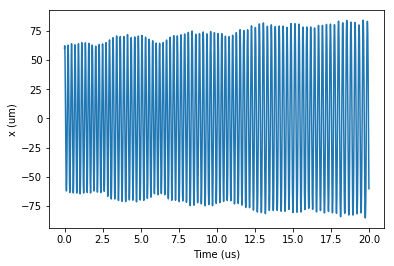

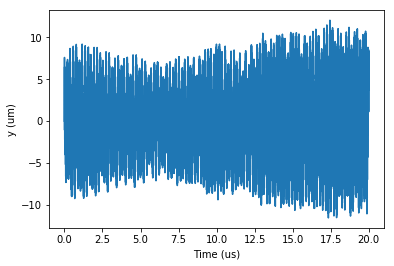

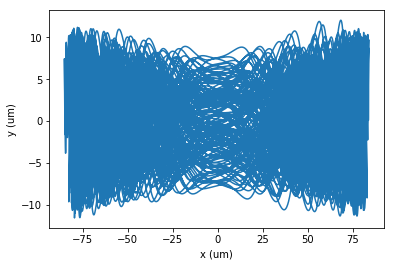

In [35]:
start = time.time()
# simulation configuration
dt = 1.0e-10 #s
t_max = 20.0e-6 # maximum time duration of the simulation

T = 300.0 # kelvin
rou = 60.0e-6 # distance from initial position to the trap center
phi = 0.0 # direction of initial position vector
v = np.sqrt(3*kB*T/m) #speed
theta = 0.0 # direction of initial velocity

electron_pos=np.array([rou*np.cos(phi), rou*np.sin(phi)])
electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
state = np.array([electron_pos, electron_vel])
t = 0.0 # the time variable
x_traj = []
y_traj = []
t_s = []
trapped = True

# actual simulation
while t < t_max:
    x, y = state[0]
    if not within_boundary(x, y):
        print("out of bound")
        trapped = False
        break
    x_traj.append(x)
    y_traj.append(y)
    t_s.append(t)
    state = rk4(state, t, dt, E_field_sim)
    t += dt
x_traj, y_traj, t_s = np.array(x_traj), np.array(y_traj), np.array(t_s)

print("x_max = ", x_max*1.0e6, "um")
print("y_max = ", y_max*1.0e6, "um")
print("x_min = ", x_min*1.0e6, "um")
print("y_min = ", y_min*1.0e6, "um")
print("spatial resolution x: ", dx*1.0e6, "um")
print("spatial resolution y: ", dy*1.0e6, "um")
print("Time step for simulation: ", dt*1.0e9, "ns")
print("Simulation time duration: ", round(t*1.0e6, 3), "us")
end = time.time()
print("time:", end-start)

plt.figure()
plt.plot(t_s*1.0e6, x_traj*1.0e6)
plt.xlabel("Time (us)")
plt.ylabel("x (um)")

plt.figure()
plt.plot(t_s*1.0e6, y_traj*1.0e6)
plt.xlabel("Time (us)")
plt.ylabel("y (um)")

plt.figure()
plt.plot(x_traj*1.0e6, y_traj*1.0e6)
plt.xlabel("x (um)")
plt.ylabel("y (um)")

In [33]:
start = time.time()
N_ion_samples = 200
T = 300.0
t_max = 20.0e-6
FWHM = 50.0e-6
data_dt_dependence = []
for dt in [0.5e-10, 1.0e-10, 1.0e-9, 2.3e-9]:
    result = Boltzmann_sim(N_ion_samples, T, dt, t_max, FWHM)
    data_dt_dependence.append(result)
end = time.time()
print("Total Run Time: ", end-start, "s")

1  ion samples already simulated
21  ion samples already simulated
41  ion samples already simulated
61  ion samples already simulated
81  ion samples already simulated
101  ion samples already simulated
121  ion samples already simulated
141  ion samples already simulated
161  ion samples already simulated
181  ion samples already simulated
T:  300.0 Kelvin
N_samples:  200
Time step:  0.05 ns
Max Sim Time:  20.0 us
FWHM:  50.0 um
Trapping Rate:  1.0 +/- 0.0
------
1  ion samples already simulated
21  ion samples already simulated
41  ion samples already simulated
61  ion samples already simulated
81  ion samples already simulated
101  ion samples already simulated
121  ion samples already simulated
141  ion samples already simulated
161  ion samples already simulated
181  ion samples already simulated
T:  300.0 Kelvin
N_samples:  200
Time step:  0.1 ns
Max Sim Time:  20.0 us
FWHM:  50.0 um
Trapping Rate:  1.0 +/- 0.0
------
1  ion samples already simulated
21  ion samples already simu